# Data scraping

The scraped data is in 'film_info_new.csv', but we use 'film_info.csv'(scraped in Nov 2024) for visualization.

In [2]:
import requests
from bs4 import BeautifulSoup
import time
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [4]:
def getAndParseURL(url):
    # Define the request header, set Accept-Language to English
    headers = {
        'Accept-Language': 'en-US,en;q=0.9'
    }
    
    # Sending requests with customized request headers
    result = requests.get(url, headers=headers)
    soup = BeautifulSoup(result.text, 'html.parser')
    return soup

# Set the number of pages to scrpe in this url
def getfilmsURLs(url, pages=1):
    all_film_urls = []

    for page in tqdm(range(1, pages + 1), desc="Fetching Film URLs", unit="page"):
        page_url = f"{url}?page={page}"
        soup = getAndParseURL(page_url)

        # Get the movie URL of the current page
        film_urls = ["http://www.themoviedb.org/" + x.div.a.get('href') for x in soup.findAll("div", class_="card style_1")]
        
        # Add the URL of the current page to the general list
        all_film_urls.extend(film_urls)

    return all_film_urls

def scrapeFilmData(filmsURLs):
    title = []
    year = []
    score = []
    description = []
    director = []
    screenplay = []
    type_ = []
    revenue = []

    for url in tqdm(filmsURLs, desc="Scraping Film Data", unit="film"):
        time.sleep(1)

        soup = getAndParseURL(url)

        # Title
        title.append(soup.find("section", class_=re.compile("header poster")).h2.text.strip().split('(')[0].strip())
        
        # Year
        year.append(soup.find("section", class_=re.compile("header poster")).h2.text.strip().split('(')[1].split(')')[0])
        
        # Score
        score.append(soup.find("div", class_=re.compile("user_score_chart")).get("data-percent")) 
        
        # Description
        description.append(soup.find("div", class_=re.compile("overview")).p.text)
        
        # Director
        director.append(", ".join(
            profile.find("a").text 
            for profile in soup.find_all("li", class_="profile") 
            if profile.find("p", class_="character") and "Director" in profile.find("p", class_="character").text
        ))
        
        # Playwriter
        screenplay.append(", ".join(
            profile.find("a").text 
            for profile in soup.find_all("li", class_="profile") 
            if profile.find("p", class_="character") and "Screenplay" in profile.find("p", class_="character").text
        ))

        # Type
        genres = soup.find("span", class_=re.compile("genres")).findAll("a")
        type_.append(', '.join([genre.text for genre in genres]))
        
        # Revenue
        revenue.append(re.sub(r"[^0-9,.]", "", soup.find("bdi", text=re.compile("Revenue")).find_parent("p").text.strip()))

    # return the DataFrame
    scraped_data = pd.DataFrame({
        'Title': title,
        'Year': year,
        'Score': score,
        'Description': description,
        'Director': director,
        'Screenplay': screenplay,
        'Type': type_,
        'Revenue': revenue
    })
    
    return scraped_data


In [6]:
filmsURLs = getfilmsURLs(url="https://www.themoviedb.org/movie", pages=10)

Fetching Film URLs: 100%|████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.04s/page]


In [7]:
film_data = scrapeFilmData(filmsURLs)

Scraping Film Data: 100%|██████████████████████████████████████████████████████████| 200/200 [08:00<00:00,  2.40s/film]


In [15]:
# Test: scrape one url
# li = ['https://www.themoviedb.org/movie/831815-saving-bikini-bottom-the-sandy-cheeks-movie']
# scrapeFilmData(li)

Scraping Film Data: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/film]


,title,year,score,description,director,screenplay,type,revenue
0,Saving Bikini Bottom: The Sandy Cheeks Movie,2024,59,"When Bikini Bottom is scooped from the ocean, ...",Liza Johnson,,"Animation, Comedy, Adventure, Family",


In [8]:
film_data.head(10)

,Title,Year,Score,Description,Director,Screenplay,Type,Revenue
0,The Old Guard 2,2025,62,Andy and her team of immortal warriors fight w...,Victoria Mahoney,Greg Rucka,"Action, Fantasy",
1,Ballerina,2025,74,Taking place during the events of John Wick: C...,Len Wiseman,,"Action, Thriller, Crime","108,372,988.00"
2,Karate Kid: Legends,2025,72,"After a family tragedy, kung fu prodigy Li Fon...",Jonathan Entwistle,,"Action, Adventure, Drama","104,518,853.00"
3,Ice Road: Vengeance,2025,70,Big rig ice road driver Mike McCann travels to...,Jonathan Hensleigh,,"Action, Thriller, Drama",
4,Heads of State,2025,70,The UK Prime Minister and US President have a ...,Ilya Naishuller,"Harrison Query, Josh Appelbaum, André Nemec","Action, Thriller, Comedy",
5,Thunderbolts*,2025,74,After finding themselves ensnared in a death t...,Jake Schreier,"Eric Pearson, Joanna Calo","Action, Science Fiction, Adventure","382,001,353.00"
6,Jurassic World Rebirth,2025,65,Five years after the events of Jurassic World ...,Gareth Edwards,,"Science Fiction, Adventure, Action","349,368,875.00"
7,Superman,2025,73,"Superman, a journalist in Metropolis, embarks ...",James Gunn,,"Science Fiction, Adventure, Action","21,000,000.00"
8,Final Destination Bloodlines,2025,72,"Plagued by a violent recurring nightmare, coll...","Zach Lipovsky, Adam B. Stein","Guy Busick, Lori Evans Taylor","Horror, Mystery","284,868,433.00"
9,Dora and the Search for Sol Dorado,2025,71,"Dora, Diego, and their new friends trek throug...",Alberto Belli,JT Billings,"Adventure, Comedy, Family",


In [9]:
film_data.to_csv('./film_info_new.csv', index=False, encoding='utf-8-sig')

# Data visualization and analysis

# Topic: How to create the best movie through early selection (type, director, etc.)?

# Introduction
As an investor, I hope my films will receive higher profits. As a movie watcher, I often want to watch movies with better reputations. The success of a movie is often related to revenue and scores. In order to explore which movies are more successful, we want to find out the factors that influence a movie's success, such as type, director, etc. By paying attention to the movie's ratings and revenue, we can find which movies are more powerful. In this section, our topic is 'how to create the best movie through early selection (type, director, etc.)'.

To begin with, we will go through the data we already scaped, handling missing values and columns. Then we will make further analysis with visualization methods. Finally, we will give conclusion on what we have found and give my answer for this topic.

### Methods
We firstly go through the data we scaped, and use `films_df.info()` to view **Non-Null Count**. 

In [3]:
films_df = pd.read_csv('./film_info.csv')
films_df.head()

,Title,Year,Score,Description,Director,Screenplay,Type,Revenue
0,Venom: The Last Dance,2024,67,Eddie and Venom are on the run. Hunted by both...,Kelly Marcel,Kelly Marcel,"Science Fiction, Action, Adventure","175,000,000.00"
1,The Wild Robot,2024,86,"After a shipwreck, an intelligent robot called...",Chris Sanders,Chris Sanders,"Animation, Science Fiction, Family","232,785,520.00"
2,Terrifier 3,2024,74,Five years after surviving Art the Clown's Hal...,Damien Leone,NaN,"Horror, Thriller","46,694,902.00"
3,Transformers One,2024,81,The untold origin story of Optimus Prime and M...,Josh Cooley,"Andrew Barrer, Gabriel Ferrari, Eric Pearson","Animation, Science Fiction, Adventure, Family,...","124,530,164.00"
4,The Substance,2024,73,A fading celebrity decides to use a black mark...,Coralie Fargeat,NaN,"Drama, Horror, Thriller","38,578,699.00"


In [3]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        200 non-null    object
 1   Year         200 non-null    int64 
 2   Score        200 non-null    int64 
 3   Description  200 non-null    object
 4   Director     199 non-null    object
 5   Screenplay   98 non-null     object
 6   Type         200 non-null    object
 7   Revenue      114 non-null    object
dtypes: int64(2), object(6)
memory usage: 12.6+ KB


### Data Cleaning
We can find that some movies in this data have no revenue information. However, revenue is an important attribute that we need to pay attention to. So in this topic, we delete the data with no revenue information for further anlysis. As only one line lacks director information, we juest drop it, too.
### Feature extraction and selection
In this task, we are interested in the `Revenue`, `Score`,` Director`, `Type`, and `Year` in the original data. As a result, we also drop the columns that we do not need.

In [6]:
films_df_copy = films_df.copy()

# Split the string into a list
films_df_copy['Type'] = films_df_copy['Type'].str.split(', ')

# Convert the revenue column to numeric type
films_df_copy['Revenue'] = films_df_copy['Revenue'].str.replace(',', '').str.strip()
films_df_copy['Revenue'] = pd.to_numeric(films_df_copy['Revenue'], errors='coerce')

# Filter out rows with negative or missing revenue and scores
films_df_copy = films_df_copy[(films_df_copy['Revenue'] > 0) & (films_df_copy['Score'] > 0)]
films_df_copy = films_df_copy.dropna(subset=['Revenue', 'Score', 'Director'])
films_df_copy = films_df_copy.drop(columns=['Description','Screenplay'])

In [7]:
films_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 199
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Title     114 non-null    object 
 1   Year      114 non-null    int64  
 2   Score     114 non-null    int64  
 3   Director  114 non-null    object 
 4   Type      114 non-null    object 
 5   Revenue   114 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.2+ KB


## Visualize the Data

#### Visualize the performance (score and revenue）
We use score and revenue to indicate the performance of movies. The score represents a movie’s reputation, that is, its popularity, while revenue represent profitability. 

There might be relationship between score and revenue. So we use corrlogram to test it.

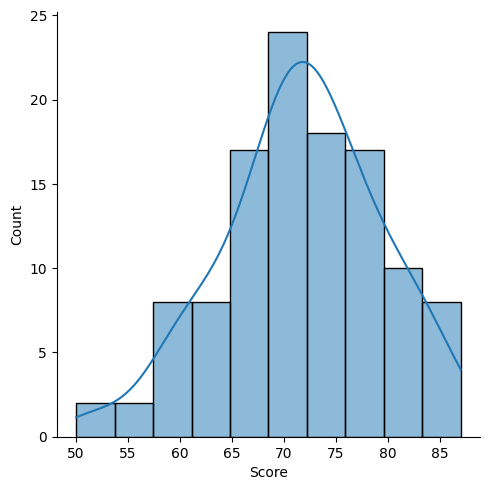

In [8]:
sns.displot(films_df_copy['Score'], kde=True) 
plt.show()

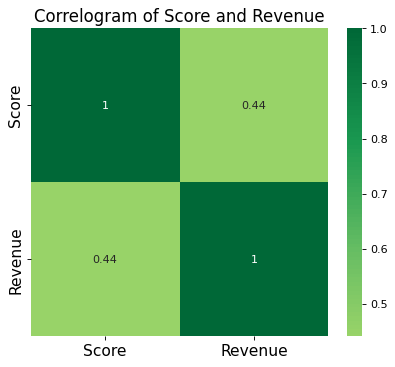

In [13]:
plt.figure(figsize=(6,5), dpi= 80)
sns.heatmap(films_df_copy[['Score','Revenue']].corr(), cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of Score and Revenue', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Anlysis
From the first chart, we can see the distribution of scores. Scores are concentrated between 65 and 80, with the highest distribution around 70.

From the corrlogram, the correlation coefficient is 0.44. This means there is a moderate relationship between revenue and scores, but it is not conclusive. Therefore, in the next exploration, we will use scatter plots to represent three-dimensional data. In this way, we can not only see the impact of other parameters on performance, but also the relationship between revenue and scores.

## Which type is the best?
People tend to have preferences for movies. Some types of movies may be more popular, garner higher scores and profits. We wanted to investigate whether movie performance is related to the type. The popularity of a category may also be related to the year and producers may also want to know what kinds of movies are hot right now.

First, we used the bar chart to describe the distribution of types in the data to understand the types and the corresponding frequencies. Then, we use the pie chart to observe difference of the popularity of types in 2024.

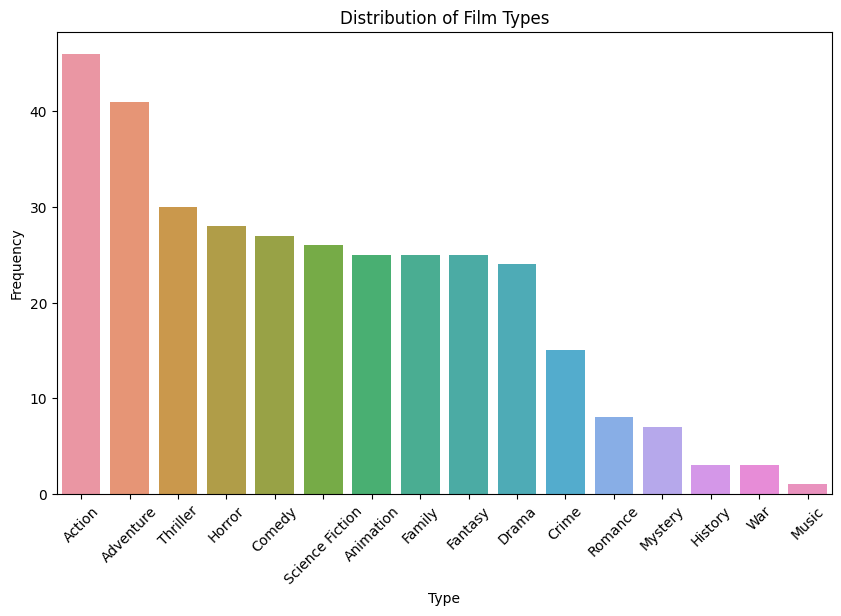

In [14]:
# Expand multiple elements separated by commas
films_df_exploded = films_df_copy.explode('Type')

# Calculate the frequency of each type
type_sums = films_df_exploded['Type'].value_counts()

# Convert to DataFrame for plotting
type_sums_df = pd.DataFrame({'Type': type_sums.index, 'Frequency': type_sums.values})
type_sums_df = type_sums_df.sort_values(by='Frequency', ascending=False)

# Use seaborn to plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Frequency', data=type_sums_df)
plt.title('Distribution of Film Types')
plt.xticks(rotation=45)
plt.xlabel('Type')
plt.ylabel('Frequency')
plt.show()

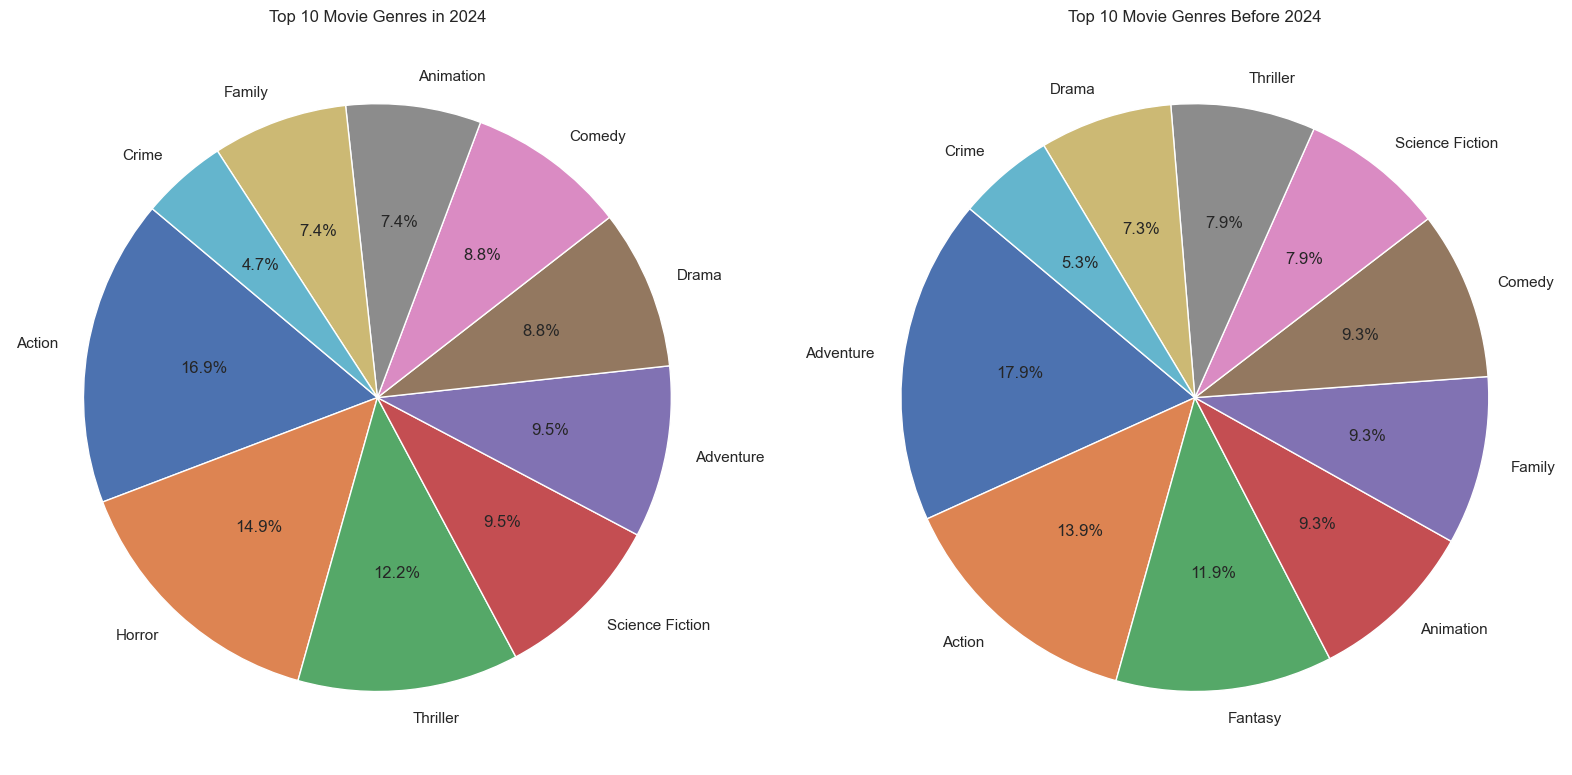

In [29]:
# Filter out the movies from the year 2024
films_2024 = films_df_exploded[films_df_exploded['Year'] == 2024]

# Calculate the frequency of each type for 2024
type_sums_2024 = films_2024['Type'].value_counts()
top_10_types_2024 = type_sums_2024.head(10)

# Filter out the movies before 2024
films_before_2024 = films_df_exploded[films_df_exploded['Year'] < 2024]

# Calculate the frequency of each type before 2024
type_sums_before_2024 = films_before_2024['Type'].value_counts()
top_10_types_before_2024 = type_sums_before_2024.head(10)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
# Plot the pie chart for movie types in 2024
axes[0].pie(top_10_types_2024, labels=top_10_types_2024.index, autopct='%1.1f%%', startangle=140)
axes[0].set_title('Top 10 Movie Genres in 2024')

# Plot the pie chart for movie types before 2024
axes[1].pie(top_10_types_before_2024, labels=top_10_types_before_2024.index, autopct='%1.1f%%', startangle=140)
axes[1].set_title('Top 10 Movie Genres Before 2024')


plt.tight_layout()
plt.show()

#### Anlysis
From the bar chart, we find the frequrncies of type from high to low. Most film types are Action and Advanture, fewest are History and Music. 

We also draw the pie chart of top ten types in 2024 and before 2024. It can be noticed that some changes in the types of movies on the market. Action(16.9%) movies are be the most in 2024, followed by Horror(14.9%) and Thriller(12.2%). Before 2024, Adventure(17.9%) movies are the most, followed by Action(13.9%) and Fantasy(11.9%).

To ensure a sufficient amount of data for subsequent exploration, we selected the top five movies shown in the bar chart for further study.

### Performance of Top 5 Movies
To explore the relationship between movie performance and type, we first plotted scatterplots depicting the relationship between revenue, score and movie types. Different colored dots were used to represent movie types, with revenue on the x-axis and type on the y-axis.

After that, we used a boxplot to show the distribution of ratings and sales of these types. It is possible to determine the median and the extent of dispersion.

In this way, we can learn more about relevant information, such as which types of movies have more stable permance, which types of movies are more likely to be bad movies, and so on.

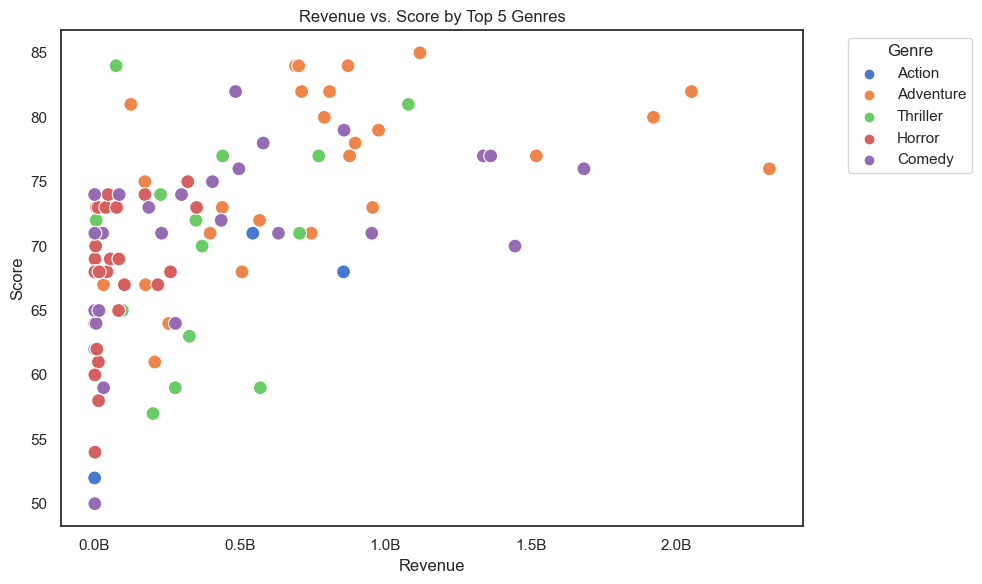

In [30]:
# Get top 5 types by frequency and sort
top_genres = films_df_exploded['Type'].value_counts().head(5).index.tolist()
films_top5 = films_df_exploded[films_df_exploded['Type'].isin(top_genres)].copy()
genre_order = films_df_exploded['Type'].value_counts().head(5).index.tolist()
films_top5['Type'] = pd.Categorical(films_top5['Type'], categories=genre_order, ordered=True)
films_top5 = films_top5.sort_values('Type')

# Define a function to format the y-axis labels in billions
def billions(x, pos):
    return '%1.1fB' % (x * 1e-9)

# Create a scatter plot for the relationship between revenue and score
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=films_top5, 
                          x='Revenue', y='Score', 
                          hue='Type', palette='muted', s=100)
plt.gca().xaxis.set_major_formatter(FuncFormatter(billions))

plt.title('Revenue vs. Score by Top 5 Genres')
plt.xlabel('Revenue')
plt.ylabel('Score')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

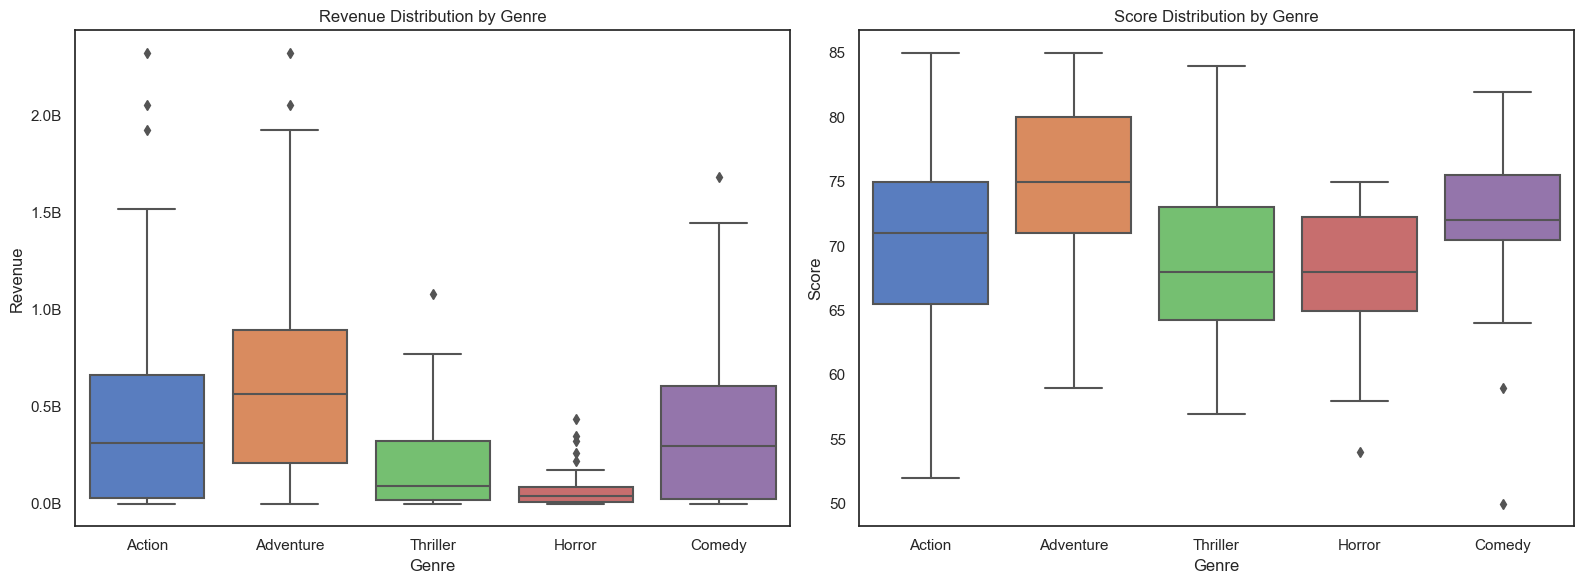

In [31]:
# Create subplots for box plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Draw the box plot for revenue
sns.boxplot(x='Type', y='Revenue', data=films_top5, ax=axes[0],palette='muted')
axes[0].set_title('Revenue Distribution by Type')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Revenue')
axes[0].yaxis.set_major_formatter(FuncFormatter(billions))

# Draw the box plot for score
sns.boxplot(x='Type', y='Score', data=films_top5, ax=axes[1],palette='muted')
axes[1].set_title('Score Distribution by Type')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

#### Anlysis
From the boxplot, there are certain differences in the distribution of revenue and ratings among different types of movies. Movies in the Adventure and Action categories performed relatively high in terms of revenue and ratings, while Thriller and Horror performed relatively low in terms of revenue and scores.

In terms of revenue, Adventure have higher revenue, followed by Action and Comedy. Horror is the lowest and the most stable.

In terms of scores, Adventure is the the highest, followed by Comedy. Comedy movies are also stable. Relatively speaking, Thriller and Horror still have the lowest ratings. While the scores of horror are more stable.

>In conclusion, if you want to make a better movie, you can consider to choose Adventure. Action is another good choice but the scores have big differences. In addition, Thriller and Horror are often disappointing so it is better not to choose them.

## Better the director, better the movie?
We also wondered whether experienced directors tend to make better movies. Among these films, some directors have created multiple films. These directors are more experienced and famous. In order to explore this issue, we first count the frequency of directors appearing in different movies in the data.

In [18]:
# Prepare the dataframe
director_df = films_df_copy.copy()
director_df['Director'] = director_df['Director'].str.split(',')
director_df = director_df.explode('Director')
director_df['Director'] = director_df['Director'].str.strip()

# Count the number of times the director appears
director_counts = director_df['Director'].value_counts()
director_counts_df = pd.DataFrame({'Director': director_counts.index, 'Frequency': director_counts.values})

director_counts

Damien Leone         3
Tim Burton           3
Peter Jackson        3
Wes Ball             2
Chris Columbus       2
                    ..
Eli Roth             1
Osgood Perkins       1
Alexandre Aja        1
SK Dale              1
Arkasha Stevenson    1
Name: Director, Length: 112, dtype: int64

#### Anlysis and visualization
It can be seen that in the data we collected, the director has filmed up to three films. Using the bubble chart, we can clearly show the relationship between the number of films filmed and the ratings and profits.

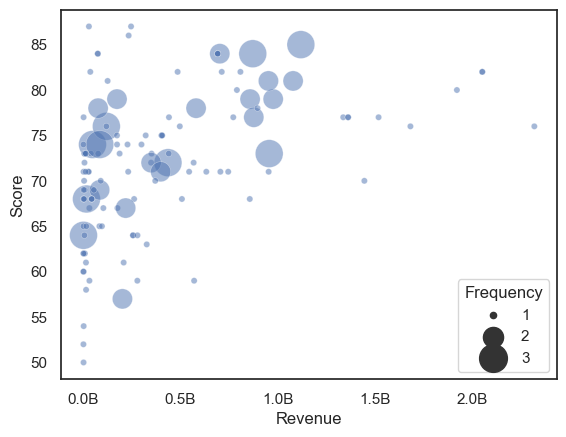

In [27]:
director_df = pd.merge(director_df, director_counts_df, how='left', left_on='Director', right_on='Director')

# use the scatterplot function
sns.scatterplot(
    data=director_df,
    x="Revenue",
    y="Score",
    size="Frequency",
    alpha=0.5,
    sizes=(20, 400)
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(billions))
plt.show()

#### Anlysis and violin chart
It can be found that directors who have made more than one movies seem to have more concentrated scores, and are pretty good with all above 55 points, and most of them between 70-80. But in terms of revenure, some unknown directors can get higher revenue.

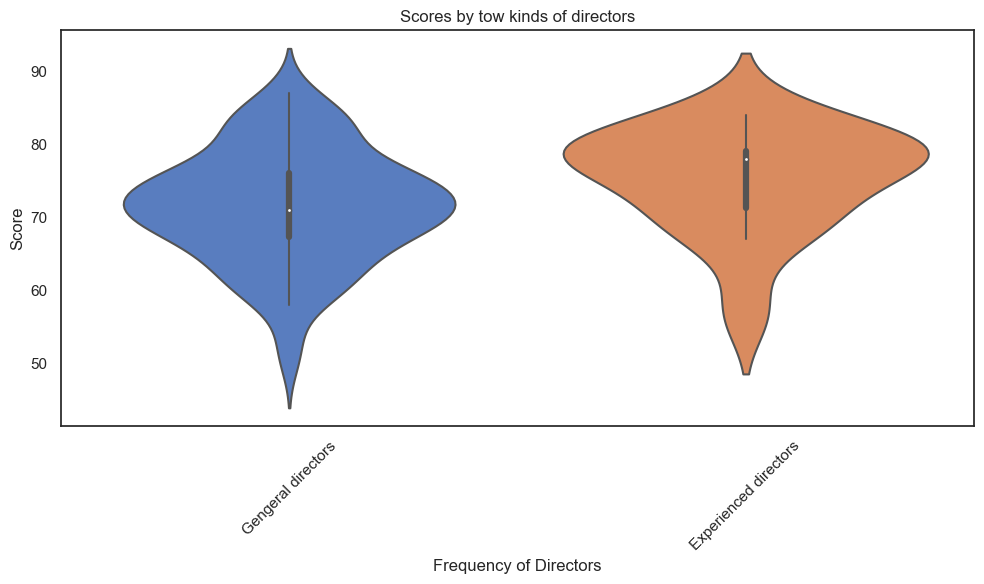

In [32]:
# Distinguish whether the director is experienced
results = {
    'Gengeral directors': [],
    'Experienced directors': []
}
for index, row in director_df.iterrows():
    frequency = row['Frequency']
    score = row['Score']
    
    if frequency == 1:
        results['Gengeral directors'].append(score)
    elif frequency == 2 or frequency == 2:
        results['Experienced directors'].append(score)
violin_data = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in results.items()]))

# Draw a violin diagram
plt.figure(figsize=(10, 6))
sns.violinplot(data=violin_data,palette='muted')
plt.title('Scores by tow kinds of directors')
plt.ylabel('Score')
plt.xlabel('Frequency of Directors')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Anlysis
The distribution of scores for general directors is wide with a main concentration area of scores is around 55-87 points, and the median is around 70 points. The distribution of scores for experienced directors is narrower, and scores are mainly concentrated between 65 and 85 points with the median about 77 points.

>As a result, the scores of movies by experienced directors are more stable, and often higher than those by general directors. The selection of directors is essential to the score of the movie.

## Discussion and Conclusion
By studying the relationship between movie type, director, revenue and ratings. We got a lot of important information, which gave us a better understanding of the film market. For example, in 2024, both Action and Thriller occupy a large market. However, the revenue of Action is often higher than that of Thriller. Our finding provides investors with important information and avoids blind choices. In addition, the choice of director also has a certain impact on the performance of the film. Experienced directors tend to receive better reviews. Therefore, when choosing a movie, you also need to pay attention to the director.

However, imited by the number of data samples, the analysis may not be comprehensive, and erroneous data will have a greater impact on the results. Therefore, in the future research, we can increase the sample size and improve the accuracy of the research.

Overall, visualization provides us with ways to study the information behind the data. In this task, we learnt that Advanture movies are the best type, and experienced directors do better.